# Standard spike-in analysis
## Dispersion of std peak

| sample #| sample | total | unique| std_pct | q_norm_0 | q_norm_1 | q_norm_5 | q_norm_10 |
|:--:|:--|-|-|-|-|-|-|-|-|
|0| UM-kSeq-A_S1_counts.txt | 5652852 | 4577426 | 0.0025700 | 0.0001903 | 0.0002236 | 0.0002355 | 0.0002373 |
|1| UM-kSeq-B_S2_counts.txt | 6058204 | 4924495 | 0.0019340 | 9.9694409 | 0.0001185 | 0.0001253 | 0.0001264 |
|2| UM-kSeq-C_S3_counts.txt | 3448606 | 2838688 | 0.0020454 | 4.1156220 | 4.8437616 | 5.1273159 | 5.1687405 |
|3| UM-kSeq-D_S4_counts.txt | 5750296 | 4638238 | 0.0021859 | 2.3230333 | 2.7469823 | 2.8909476 | 2.9190383 |
|4| UM-kSeq-E_S5_counts.txt | 5439703 | 4436241 | 0.0024429 | 1.6744100 | 1.9681153 | 2.0700491 | 2.0895790 |


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


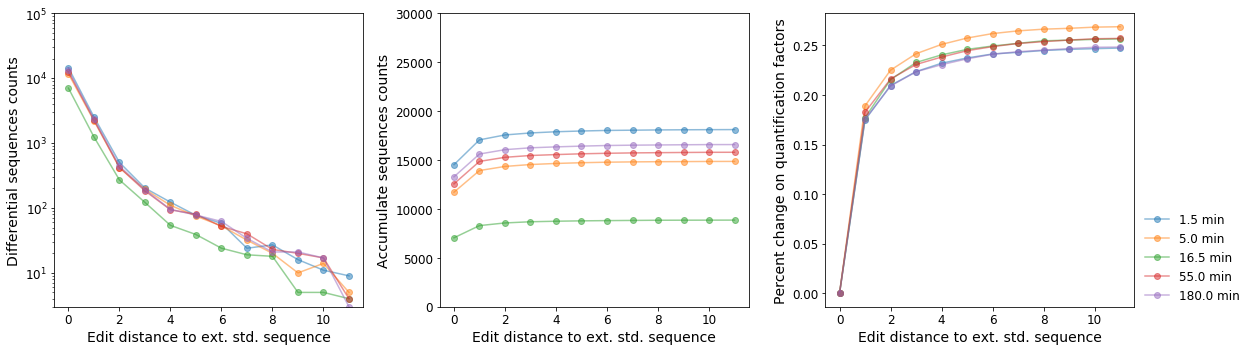

Quantification factors have been saved to /home/yuning/Work/ribozyme_pred/data/uli/


In [38]:
from __future__ import division
from yntools import dump_pickle
import numpy as np

def get_relaxed_count(sampleDirc, centerSeq, maxDist=10):
    from yntools import progress_bar, progress_checkpoint
    import numpy as np
    import Levenshtein
    
    relaxedCounts = [0 for i in range(maxDist + 1)]
    with open(sampleDirc) as file:
        unique = int(next(file).strip().split()[-1])
        total = int(next(file).strip().split()[-1])
        next(file)

        checkpoints = progress_checkpoint(unique)
        for ix,line in enumerate(file):
            seq = line.strip().split()
            dist = Levenshtein.distance(centerSeq, seq[0])
            if dist <= maxDist:
                relaxedCounts[dist] += int(seq[1])
            if ix in checkpoints:
                progress_bar(ix/unique)

    print('%s finished!' %sampleDirc)
    return [total, unique, np.array(relaxedCounts)]

def test_norm_calculation(extStdCountList):
    
    testNormList = [np.asarray([sum(relaxedCounts[2][:i+1]) for i in range(maxDist+1)])/relaxedCounts[0]/std[sampleIx]
                    for sampleIx,relaxedCounts in enumerate(extStdCountList)]
    print('| sample #| sample | total | unique| std_pct | q_norm_0 | q_norm_1 | q_norm_5 | q_norm_10 |')
    print('|:--:|:--|-|-|-|-|-|-|-|-|')
    for sampleIx,sample in enumerate(kSeqList):
        print('|%i| %s | %i | %i | %.9r | %.9r | %.9r | %.9r | %.9r |' 
              %(sampleIx, sample, extStdCountList[sampleIx][0], extStdCountList[sampleIx][1], 
                extStdCountList[sampleIx][2][0]/extStdCountList[sampleIx][0],
                testNormList[sampleIx][0], testNormList[sampleIx][1], 
                testNormList[sampleIx][5], testNormList[sampleIx][10]))
    return testNormList

def plot(extStdCountList, testNormList):
    import matplotlib.pyplot as plt
    
    symbolList = ['-o', '-s', '->', '-*', '-<', '-v']
    
    plt.figure()
    
    fig, ax = plt.subplots(1,3, figsize=[16,5])
    
    ## Fig a) 
    for sampleIx,sample in enumerate(kSeqList):
        ax[0].plot([i for i in range(maxDist+1)], extStdCountList[sampleIx][2],
                   symbolList[0], label='%.1f min' %(timePoints[sampleIx]), alpha=0.5)
    
    ax[0].set_xlabel('Edit distance to ext. std. sequence', fontsize=14)
    ax[0].tick_params(labelsize=12)
    ax[0].set_yscale('log')
    ax[0].set_ylim([0, 10**5])
    ax[0].set_ylabel('Differential sequences counts', fontsize=14)
    
    ## Fig b)
    for sampleIx,sample in enumerate(kSeqList):
        ax[1].plot([i for i in range(maxDist+1)], [sum(extStdCountList[sampleIx][2][:i+1]) for i in range(maxDist+1)],
                   symbolList[0], label='%.1f min' %(timePoints[sampleIx]), alpha=0.5)
    ax[1].set_xlabel('Edit distance to ext. std. sequence', fontsize=14)
    ax[1].tick_params(labelsize=12)
    ax[1].set_ylim([0, 3*10**4])
    ax[1].set_ylabel('Accumulate sequences counts', fontsize=14)
    
    ## Fig c)
    for sampleIx,sample in enumerate(kSeqList):
        ax[2].plot([i for i in range(maxDist+1)],
                   (testNormList[sampleIx] - testNormList[sampleIx][0])/testNormList[sampleIx][0],
                   symbolList[0], label='%.1f min' %(timePoints[sampleIx]), alpha=0.5)
    ax[2].set_xlabel('Edit distance to ext. std. sequence', fontsize=14)
    ax[2].tick_params(labelsize=12)
    # ax[2].set_ylim([0, 3*10**4])
    ax[2].set_ylabel('Percent change on quantification factors', fontsize=14)
    ax[2].legend(loc=[1.02,0], fontsize=12, frameon=False)
    
    plt.tight_layout()
    plt.show()

if __name__=='__main__':
    root = '/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq/counts/'
    kSeqList = ['UM-kSeq-A_S1_counts.txt', 'UM-kSeq-B_S2_counts.txt', 'UM-kSeq-C_S3_counts.txt', 
                'UM-kSeq-D_S4_counts.txt', 'UM-kSeq-E_S5_counts.txt']
    
    stdSeq = 'TGTTCTAATGCGATACTGTGCGAGACACCATTTAATACGACTGCATACTGTCTCCATCTGACAGGTCCATCCCCCGCTTTCTCGTATTGGATTCGACAAGCCGCGGTCAAATAAACGTCTTACGATAGTACGATACCGTGGGTTGTATTAGACCCGCC'
    maxDist = 11
    timePoints = [1.5, 5, 16.5, 55, 180]
    std = [13.5, 19.4, 49.7, 94.1, 145.9] # unit fmol
    
    stdOutDirc = '/home/yuning/Work/ribozyme_pred/data/uli/'
    
    # extStdCountList = [get_extStd_relaxed_count(root + sample, stdSeq) for sample in kSeqList]
    testNormList = test_norm_calculation(extStdCountList)
    plot(extStdCountList, testNormList)
    
    dump_pickle(extStdCountList, stdOutDirc + 'std_count_list.pkl')
    dump_pickle(testNormList, stdOutDirc + 'q_factor_list.pkl')
    print('Quantification factors have been saved to %s' %'/home/yuning/Work/ribozyme_pred/data/uli/')

[====================] 98%/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq_CMTP/counts/UM-kSeq-A_S1_counts.txt finished!
[====================] 98%/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq_CMTP/counts/UM-kSeq-B_S2_counts.txt finished!
[====================] 97%/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq_CMTP/counts/UM-kSeq-C_S3_counts.txt finished!
[====================] 98%/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq_CMTP/counts/UM-kSeq-D_S4_counts.txt finished!
[====================] 97%/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq_CMTP/counts/UM-kSeq-E_S5_counts.txt finished!
| sample #| sample | total | unique| std_pct | q_norm_0 | q_norm_1 | q_norm_5 | q_norm_10 |
|:--:|:--|-|-|-|-|-|-|-|-|
|0| UM-kSeq-A_S1_counts.txt | 4355309 | 3511012 | 0.0025816 | 0.0001912 | 0.0002178 | 0.0002205 | 0.0002205 |
|1| UM-kSeq-B_S2_counts.txt | 4648770 | 3761652 | 0.0019695 | 0.0001015 | 0.0001162 | 0.0001176 | 0.0001176 |
|2| UM-kSeq-C_S3_counts.txt | 2509434 | 2058433 | 0.0020622 | 4.1493320

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


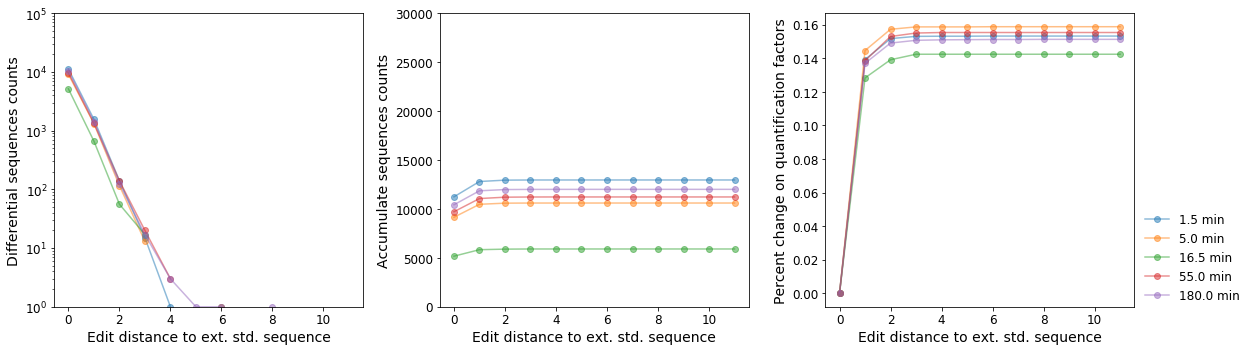

Quantification factors have been saved to /home/yuning/Work/ribozyme_pred/data/uli/


In [39]:
if __name__=='__main__':
    root = '/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq_CMTP/counts/'
    kSeqList = ['UM-kSeq-A_S1_counts.txt', 'UM-kSeq-B_S2_counts.txt', 'UM-kSeq-C_S3_counts.txt', 
                'UM-kSeq-D_S4_counts.txt', 'UM-kSeq-E_S5_counts.txt']
    
    stdSeq = 'TGTTCTAATGCGATACTGTGCGAGACACCATTTAATACGACTGCATACTGTCTCCATCTGACAGGTCCATCCCCCGCTTTCTCGTATTGGATTCGACAAGCCGCGGTCAAATAAACGTCTTACGATAGTACGATACCGTGGGTTGTATTAGACCCGCC'
    maxDist = 11
    timePoints = [1.5, 5, 16.5, 55, 180]
    std = [13.5, 19.4, 49.7, 94.1, 145.9] # unit fmol
    
    stdOutDirc = '/home/yuning/Work/ribozyme_pred/data/uli/'
    
    extStdCountList = [get_extStd_relaxed_count(root + sample, stdSeq) for sample in kSeqList]
    testNormList = test_norm_calculation(extStdCountList)
    plot(extStdCountList, testNormList)
    
    dump_pickle(extStdCountList, stdOutDirc + 'std_count_list_CMTP.pkl')
    dump_pickle(testNormList, stdOutDirc + 'q_factor_list_CMTP.pkl')
    print('Quantification factors have been saved to %s' %'/home/yuning/Work/ribozyme_pred/data/uli/')

# Count table for sequences detected in Round 7-3h

In [ ]:
from yntools import load_pickle, dump_pickle
from k_seq import countAll
from __future__ import division


if __name__=='__main__':
    
    root = '/mnt/chen-nas/SequenceData/071318_UM_TMP_kSeq/counts/'
    kSeqList = ['UM-kSeq-A_S1_counts.txt', 'UM-kSeq-B_S2_counts.txt', 'UM-kSeq-C_S3_counts.txt', 
                'UM-kSeq-D_S4_counts.txt', 'UM-kSeq-E_S5_counts.txt']
    masterDirc = '/home/yuning/Work/ribozyme_pred/data/uli/count-7-3h.txt'

    seqList = {}
    with open(masterDirc) as file:
        unique = int(next(file).strip().split()[-1])
        total = int(next(file).strip().split()[-1])
        next(file)
        for ix,line in enumerate(file):
            seq = line.strip().split()
            seqList['TGTT'+seq[0]+'CGCC'] = [[int(seq[1]), 0, 0, 0, 0, 0], 0]
    
    for sampleIx,sample in enumerate(kSeqList):
        with open(root + sample) as file:
            next(file)
            next(file)
            next(file)
            for ix,line in enumerate(file):
                seq = line.strip().split()
                if seq[0] in seqList:
                    seqList[seq[0]][0][sampleIx+1] = int(seq[1])
                    seqList[seq[0]][1] += 1
    
    # Save count table
    outDirc = '/home/yuning/Work/ribozyme_pred/data/uli/seq_count_raw.pkl'
    dump_pickle(seqList, outDirc)
    print('Sequence counts saved to %s' %outDirc)

[672061, 60465, 33875, 24713, 21636, 32862]


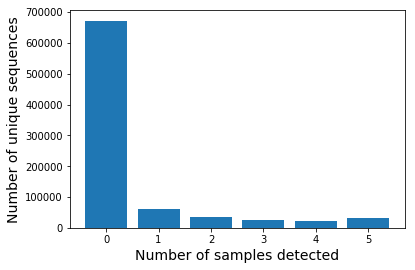

In [2]:
from yntools import load_pickle, dump_pickle
import matplotlib.pyplot as plt

seqList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/seq_count_raw_CMTP.pkl')
cat = [sum([1 for seq in seqList.values() if seq[1]==i]) for i in range(6)]

print(cat)

plt.figure()
plt.bar([0, 1, 2, 3, 4, 5], cat)
plt.xlabel('Number of samples detected', fontsize=14)
plt.ylabel('Number of unique sequences', fontsize=14)
plt.show()


# Data fitting

## Only on test seqs

In [17]:
def normalization():
    seqList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/seq_count_raw.pkl')
    extStdCountList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/std_count_list.pkl')
    qFactorList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/q_factor_list.pkl')
    
    print('Raw sequence counts loaded, converting to normalized ratios...')
    countTable = []

    for testSeq in testSeqs:
        seq = seqList['TGTT'+testSeq[1]+'CGCC']
        print(testSeq[0])
        print(seq)
        countTable.append(['TGTT'+testSeq[1]+'CGCC', seq[0][0], [seq[0][i+1]/(float(extStdCountList[i][0])*qFactorList[i][2])/(seq[0][0]/1560875.0*200000.0) for i in range(5)],
                               seq[1]])
    print('Sequence counts converted to normalized ratios.')
    return countTable

def fitting(countTable):
    from scipy.optimize import curve_fit
    from yntools import progress_bar, progress_checkpoint
    
    def func(x, A, k):
        return A * (1 - np.exp(- k * x))
    
    xdata = np.array([1.5, 5, 16.5, 55, 180])   # min
    seqNum = len(countTable)
    checkpoints = progress_checkpoint(seqNum)
    for ix,seq in enumerate(countTable):
        ydata = np.array(seq[2])
        valid = ydata > 0
        try:
            params, pcov = curve_fit(func, xdata=xdata[valid], ydata=ydata[valid],
                                    method='trf', bounds = ([0,0], [np.inf, np.inf]))
        except RuntimeError:
            params = [np.nan, np.nan]
        seq.append(params)
        if ix in checkpoints:
            progress_bar(ix/len(countTable))
    return countTable

testSeqs = [
    ['AP10','AGAAACACGTTGGAATGATGGGAATGTCCCATTCCGCGGTCTAAATATGAGTACAGAATAAGAGAACGTTTATATAATAGTGCTCTTGAATAATCCGTTACGGCCGGGATCGACCACGAGATGCCATCGGTGGTTCTTCAGTTTGGCCCT'],
    ['AP12','GGGCCCACGCATGTGCCCCGAGCTCCCACAACTGCGCTGTGCTTTAGTCACAGTGAGGACGTCTACTTGTAACAGCTGACCGTGTCGACGTAGAGACTACTAAGACGCACTCAGCTATGTACACTAGCTCACGCAAATCCGGATTCAACT'],
    ['AP15','ACTACTGGAATGACGTATTTCAATAAGAAAATTAAAGAATGGAAGATTAAGGCACACCTTAGATGACTCCACACCGTAACTTCCCTAACGAGCTGCCACACTGAAACAGCGGTTATCTCTCGGGACTAATCCGTGTCTGTTTCAGGATGA'],
    ['AP19','GAAAGTAAACACCTGTTGTTTCCCGGTATTGAATGCCGCAGCGGGTTGAACTGCATTCCTGGGTCGCGCTTAGGATCCCAGATCCCGACGATTCAGTAAAATCTGCTGCGACGTACGAACTGAAATAATTCATATACGGCCAAGCCTTCT'],
    ['AP20','GGGCCCACGCATGTGCCCCGAGCTCCCACAACTGCGCTGTGCTTTAGTCACAGTGAGGACGTCTACTTGTAACAGCTGACCGTGTCGACGTAGAGACTACTAAGACGCACTCAGCTATGTAATCTAGCTCACGCAAATCCGGATTCAACT'],
    ['AP37','GCAGGAACGAGATGACTCAGAACTGAAATAACAGAACTACGAGGCCATGCAGGCCGCATATCCGCGCGGTATCTGTATATAATCGTAGCCACCATGTGCCGTCCGTAGAAAAACCTAAACGTCAATTGGCAAAAACAGTAATCTTTTTCGA'],
    ['AP40','CGTGCGCGGGCCGCGCTACCCTCACCCGCGTATGATGAAAATGAAATGTTAGCTACGCTCTTTGCGTGTCTGCTTATGACGTTTCCCGAACTTGGAGGCTCGGCCAAGATACAGTACTCCCTTTCAGATAACTACAGTAAGGCCTACTGT'],
    ['AP49','ACCCGATCAACGCGCTGAAAGGTGGTAGCCTATGCGGCTTACCGGTTTATAAAGCGTCTGTGTTTACGATGAGCGATCGATCGATTTCTTCCGCTTCCGCGATATGAAATTGCTCAATAAGTTCTAGCCTTTCCCGCCTACGGATATGTG'],
    ['AP55','GCCCACCGAAAAGCCATCGGGCTGCGTGGAGGAAGAGACTGAGTATAAAACCTCGTACTCTTCTTCCGGATACGCTCGATTTCCACTTCGATTAGGCTGAAACCTGATATGGGCATGAGCGCTCTATTCCCGGAATGGCGAACTATCATCG'],
    ['AP56','CTCTTGTAGTACGGTTGCATGTAATCATAAGCTATATGTACGGAGACTACCGCCAAGACCAAACCTTTGGTTCCCTAAATTGAAAGACTAGTAGCCCAAAAATCAAAATAATAAGGACTTAAGCGAAGACGTCTACCTCTGCCGTTTCCT']
]

normalization()


Raw sequence counts loaded, converting to normalized ratios...
AP10
[[72, 126, 106, 49, 20, 26], 5]
AP12
[[21, 74, 52, 13, 26, 10], 5]
AP15
[[11, 31, 33, 7, 15, 12], 5]
AP19
[[79, 180, 164, 74, 114, 113], 5]
AP20
[[48, 165, 141, 52, 56, 23], 5]
AP37
[[30, 166, 113, 63, 69, 34], 5]
AP40
[[34, 51, 91, 37, 40, 23], 5]
AP49
[[404, 1142, 1709, 1081, 1202, 825], 5]
AP55
[[359, 1066, 978, 531, 658, 386], 5]
AP56
[[14, 188, 160, 81, 64, 32], 5]
Sequence counts converted to normalized ratios.


[['TGTTAGAAACACGTTGGAATGATGGGAATGTCCCATTCCGCGGTCTAAATATGAGTACAGAATAAGAGAACGTTTATATAATAGTGCTCTTGAATAATCCGTTACGGCCGGGATCGACCACGAGATGCCATCGGTGGTTCTTCAGTTTGGCCCTCGCC',
  72,
  [0.010493333297763361,
   0.01553104943755419,
   0.030791105209993907,
   0.01334626699196743,
   0.025594906218660302],
  5],
 ['TGTTGGGCCCACGCATGTGCCCCGAGCTCCCACAACTGCGCTGTGCTTTAGTCACAGTGAGGACGTCTACTTGTAACAGCTGACCGTGTCGACGTAGAGACTACTAAGACGCACTCAGCTATGTACACTAGCTCACGCAAATCCGGATTCAACTCGCC',
  21,
  [0.021129433034952072,
   0.0261223041752933,
   0.02800823564290991,
   0.059486218592769126,
   0.033751524683947653],
  5],
 ['TGTTACTACTGGAATGACGTATTTCAATAAGAAAATTAAAGAATGGAAGATTAAGGCACACCTTAGATGACTCCACACCGTAACTTCCCTAACGAGCTGCCACACTGAAACAGCGGTTATCTCTCGGGACTAATCCGTGTCTGTTTCAGGATGACGCC',
  11,
  [0.01689835492107347,
   0.031648176212374576,
   0.028791682793760542,
   0.0655180379605674,
   0.07732167473049827],
  5],
 ['TGTTGAAAGTAAACACCTGTTGTTTCCCGGTATTGAATGCCGCAGCGGGTTGAACTGCATTCCTGGGTCGCGCTTAGGATCCCAGATCCCGACGATTCAG

## On all valid seqs

In [16]:
import numpy as np
from yntools import load_pickle, dump_pickle


def normalization():
    seqList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/seq_count_raw_CMTP.pkl')
    extStdCountList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/std_count_list_CMTP.pkl')
    qFactorList = load_pickle('/home/yuning/Work/ribozyme_pred/data/uli/q_factor_list_CMTP.pkl')
    
    print('Raw sequence counts loaded, converting to normalized ratios...')
    countTable = []
    for seq in seqList.items():
        if seq[1][1]>0:
            countTable.append([seq[0], seq[1][0][0], [seq[1][0][i+1]/(float(extStdCountList[i][0])*qFactorList[i][2])/(seq[1][0][0]/1560875.0*200000.0) for i in range(5)],
                              seq[1][1]])
    print('Sequence counts converted to normalized ratios.')
    return countTable

def fitting(countTable):
    from scipy.optimize import curve_fit
    from yntools import progress_bar, progress_checkpoint
    
    def func(x, A, k):
        return A * (1 - np.exp(- k * x))
    
    xdata = np.array([1.5, 5, 16.5, 55, 180])   # min
    seqNum = len(countTable)
    checkpoints = progress_checkpoint(seqNum)
    for ix,seq in enumerate(countTable):
        ydata = np.array(seq[2])
        valid = ydata > 0
        try:
            params, pcov = curve_fit(func, xdata=xdata[valid], ydata=ydata[valid],
                                    method='trf', bounds = ([0,0], [np.inf, np.inf]))
        except RuntimeError:
            params = [np.nan, np.nan]
        seq.append(params)
        if ix in checkpoints:
            progress_bar(ix/len(countTable))
    return countTable
        
if __name__=='__main__':
    
    countTable = normalization()
    countTableFitted = fitting(countTable)
    dump_pickle(countTableFitted, '/home/yuning/Work/ribozyme_pred/data/uli/fitting_results_200000_CMTP.pkl')

Raw sequence counts loaded, converting to normalized ratios...
Sequence counts converted to normalized ratios.
[                    ] 0%

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[====================] 98%

In [120]:
[seq[-1] for seq in countTable[:100]]

[array([9.49014824, 1.        ]),
 array([46.53290508,  0.07866778]),
 array([2.40232806, 1.        ]),
 array([6.83835221, 0.20606376]),
 array([5.18332274, 0.0515438 ]),
 array([7.08782018, 1.        ]),
 array([1.06289471, 0.97897747]),
 array([1.06289471, 0.97897747]),
 array([8.46800342, 0.07347065]),
 array([1.06289471, 0.97897747]),
 array([0.80346913, 0.91436929]),
 array([14.17564041,  1.        ]),
 array([2.40232806, 1.        ]),
 array([2.62487372, 0.04486647]),
 array([0.52747568, 2.27384427]),
 array([16.38393646,  0.02071888]),
 array([7.23380504, 0.02057726]),
 array([1.15590541, 0.48757068]),
 array([7.08782018, 1.        ]),
 array([7.08799559, 0.05892683]),
 array([3.80454395, 0.05472092]),
 array([1.3970034, 0.0252278]),
 array([4.80478472, 0.1914259 ]),
 array([1.62922508, 0.13365819]),
 array([9.60931223, 1.        ]),
 array([0.80346913, 0.91436929]),
 array([7.08075031, 0.04826865]),
 array([3.60429811, 0.02097434]),
 array([3.13543621, 0.05670403]),
 array([11